In [20]:
%matplotlib inline
from matplotlib import pyplot
import geopandas
import numpy as np

from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.affinity import scale
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import LineString

from shapely.wkt import dumps
from shapely.wkt import loads

from tile_units import TileUnit
from tile_map import Tiling

In [21]:
ak = geopandas.read_file("../data/imd-auckland-2018.gpkg")

# H3 tiles
Note really H3 per se, but a rescaling of the regular hex tiling suitably rotated and with the tiles further rescaled so they have a margin around them that makes it possible to 'indexically' determine which is which.

In [66]:
d = 600
tile_unit = TileUnit(spacing = d, crs = 2193, shape = "hexagon")

In [71]:
# the basic H3 level to level scale factor and rotation
sf = 1 / np.sqrt(7)  
rotation = np.degrees(np.arctan(1 / 3 / np.sqrt(3)))

# inset scaling
sf2 = 0.9

hex = scale(tile_unit.tile.geometry[0], sf, sf)
corners = [p for p in hex.exterior.coords]
hex = rotate(hex, 30)
hexes = [hex] + [translate(
    hex, x * np.sqrt(3), y * np.sqrt(3)) for x, y in corners]
hexes = geopandas.GeoSeries(hexes, crs = ak.crs).rotate(
    rotation, origin = (0, 0)).scale(sf2, sf2, origin = (0, 0))

<AxesSubplot:>

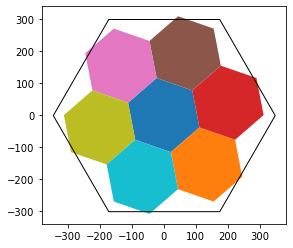

In [74]:
tile_unit.elements = geopandas.GeoDataFrame(
    data = {"element_id": list("abcdefg")}, crs = ak.crs,
    geometry = hexes
)
ax = tile_unit.elements.plot(column = "element_id")
tile_unit.tile.plot(ax = ax, edgecolor = "k", facecolor = "#00000000")

In [75]:
tiling = Tiling(tile_unit, ak, id_var = "DZ2018")
t30 = tiling.get_tiled_map(prioritise_tiles = True)

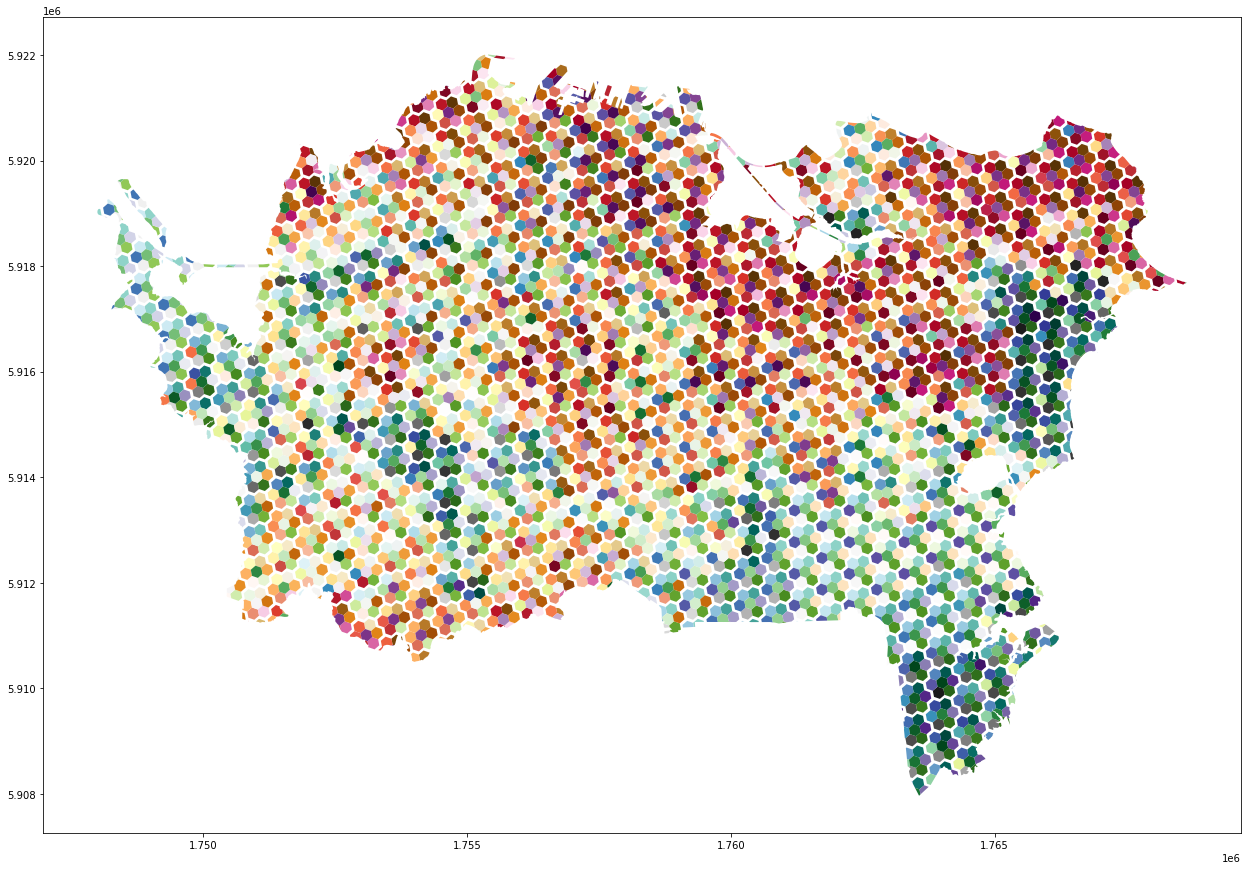

In [76]:
fig = pyplot.figure(figsize = (24, 15))
ax = fig.add_subplot(111)

strands = set(t30.element_id)
cols = [x for x in t30.columns if "Rank" in x]
cmaps = ("BrBG", "RdGy", "RdYlBu", "Spectral",
         "PiYG", "PRGn", "PuOr", "viridis")

for strand, col, cmap in zip(strands, cols, cmaps):
    t30[t30.element_id == strand].plot(ax = ax, column = col, cmap = cmap)